![tower_bridge](tower_bridge.jpeg)

As the climate changes, predicting the weather becomes ever more important for businesses. Since the weather depends on a lot of different factors, you will want to run a lot of experiments to determine what the best approach is to predict the weather. In this project, you will run experiments for different regression models predicting the mean temperature, using a combination of `sklearn` and `MLflow`.

You will be working with data stored in `london_weather.csv`, which contains the following columns:
- **date** - recorded date of measurement - (**int**)
- **cloud_cover** - cloud cover measurement in oktas - (**float**)
- **sunshine** - sunshine measurement in hours (hrs) - (**float**)
- **global_radiation** - irradiance measurement in Watt per square meter (W/m2) - (**float**)
- **max_temp** - maximum temperature recorded in degrees Celsius (°C) - (**float**)
- **mean_temp** - mean temperature in degrees Celsius (°C) - (**float**)
- **min_temp** - minimum temperature recorded in degrees Celsius (°C) - (**float**)
- **precipitation** - precipitation measurement in millimeters (mm) - (**float**)
- **pressure** - pressure measurement in Pascals (Pa) - (**float**)
- **snow_depth** - snow depth measurement in centimeters (cm) - (**float**)

In [179]:
# Run this cell to import the modules you require
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Read in the data
weather = pd.read_csv("london_weather.csv")


In [180]:
# Investigate the data
# Start coding here
weather.dtypes


date                  int64
cloud_cover         float64
sunshine            float64
global_radiation    float64
max_temp            float64
mean_temp           float64
min_temp            float64
precipitation       float64
pressure            float64
snow_depth          float64
dtype: object

In [181]:
weather.var()

date                1.469370e+10
cloud_cover         4.285199e+00
sunshine            1.622752e+01
global_radiation    7.902903e+03
max_temp            4.296479e+01
mean_temp           3.282956e+01
min_temp            2.837433e+01
precipitation       1.397668e+01
pressure            1.101918e+06
snow_depth          2.977152e-01
dtype: float64

In [182]:
# describe data in 2 decimal places
weather.describe().round(2)


,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
count,15341.00,15322.00,15341.00,15322.00,15335.00,15305.00,15339.00,15335.00,15337.00,13900.00
mean,19995671.59,5.27,4.35,118.76,15.39,11.48,7.56,1.67,101536.61,0.04
std,121217.56,2.07,4.03,88.90,6.55,5.73,5.33,3.74,1049.72,0.55
min,19790101.00,0.00,0.00,8.00,-6.20,-7.60,-11.80,0.00,95960.00,0.00
25%,19890702.00,4.00,0.50,41.00,10.50,7.00,3.50,0.00,100920.00,0.00
50%,20000101.00,6.00,3.50,95.00,15.00,11.40,7.80,0.00,101620.00,0.00
75%,20100702.00,7.00,7.20,186.00,20.30,16.00,11.80,1.60,102240.00,0.00
max,20201231.00,9.00,16.00,402.00,37.90,29.00,22.30,61.80,104820.00,22.00


In [183]:
# Cleaning and conversion of data

# Convert date to datetime from YYYYMMDD format
weather['date'] = pd.to_datetime(weather['date'], format='%Y%m%d')
# convert date to dd/mm/yyyy format
weather['date'] = weather['date'].dt.strftime('%d/%m/%Y')
# Ensure 'date' is datetime type before extracting day, month, year
weather['date'] = pd.to_datetime(weather['date'], format='%d/%m/%Y')
weather['day'] = weather['date'].dt.day
weather['month'] = weather['date'].dt.month
weather['year'] = weather['date'].dt.year
#weather.drop(columns=['date'], inplace=True)

In [184]:
# check for missing values
print(weather.isnull().sum())


date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
day                    0
month                  0
year                   0
dtype: int64


In [185]:
# impute cloud_cover with simpleimputer
imputer = SimpleImputer(strategy='mean')
weather[['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth', 'mean_temp']] = imputer.fit_transform(weather[['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth', 'mean_temp']])


# check for missing values again
print(weather.isnull().sum())

date                0
cloud_cover         0
sunshine            0
global_radiation    0
max_temp            0
mean_temp           0
min_temp            0
precipitation       0
pressure            0
snow_depth          0
day                 0
month               0
year                0
dtype: int64


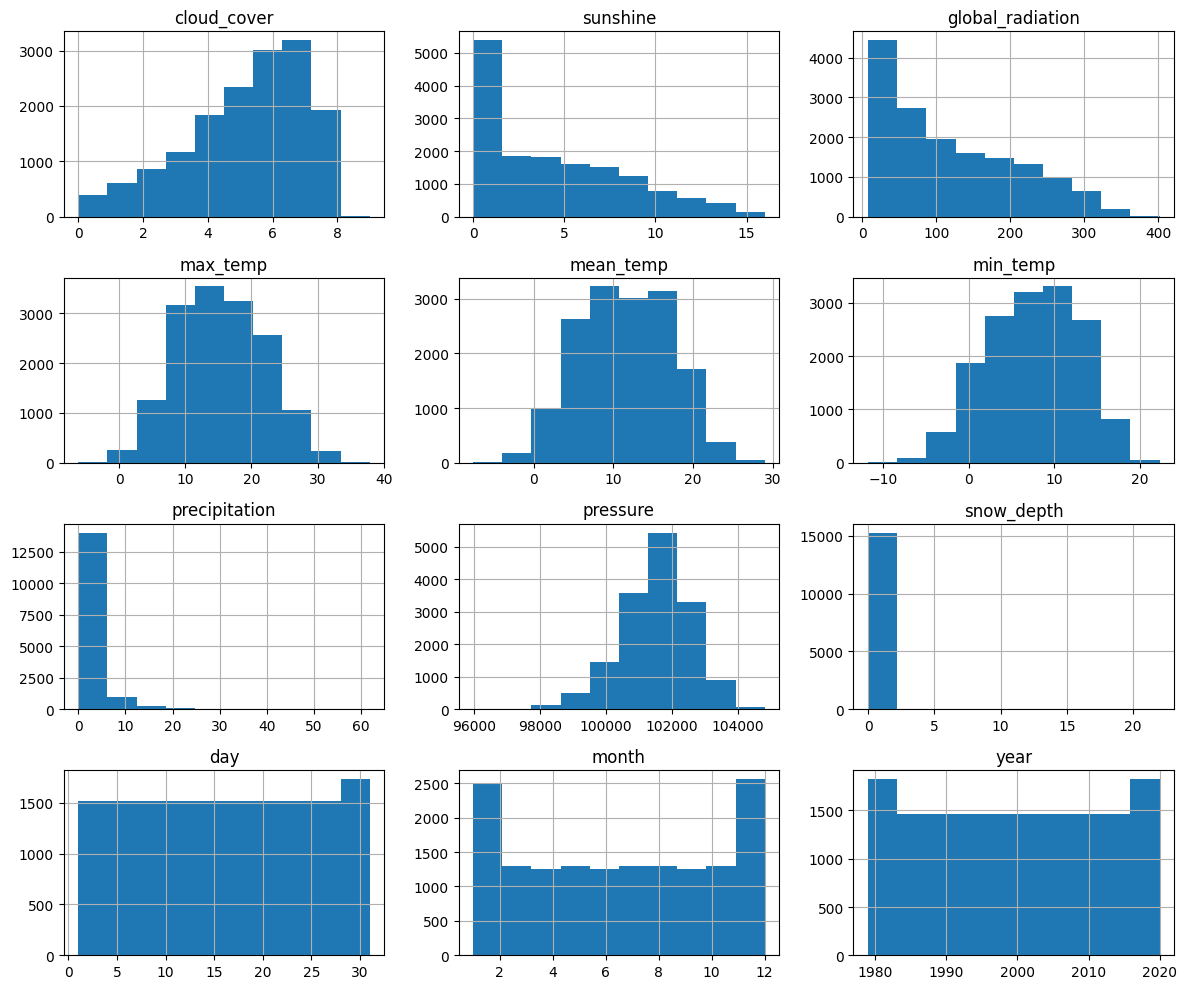

In [186]:
# Exploratory data analysis
# Visual Inspection of data
# create histograms of all numeric parameters (exclude 'date')
numeric_cols = weather.select_dtypes(include=[np.number]).columns
axes = weather[numeric_cols].hist(layout=(4,3), figsize=(12,10))
plt.tight_layout()
plt.show()

# create histograms of all parameters except date
#axes = weather[['mean_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth']].hist(layout=(2,3), figsize=(12,8))
# Remove the unused subplot (last one)
#fig = axes[0,0].figure
#fig.delaxes(axes[1,2])
#plt.tight_layout()
#plt.show()

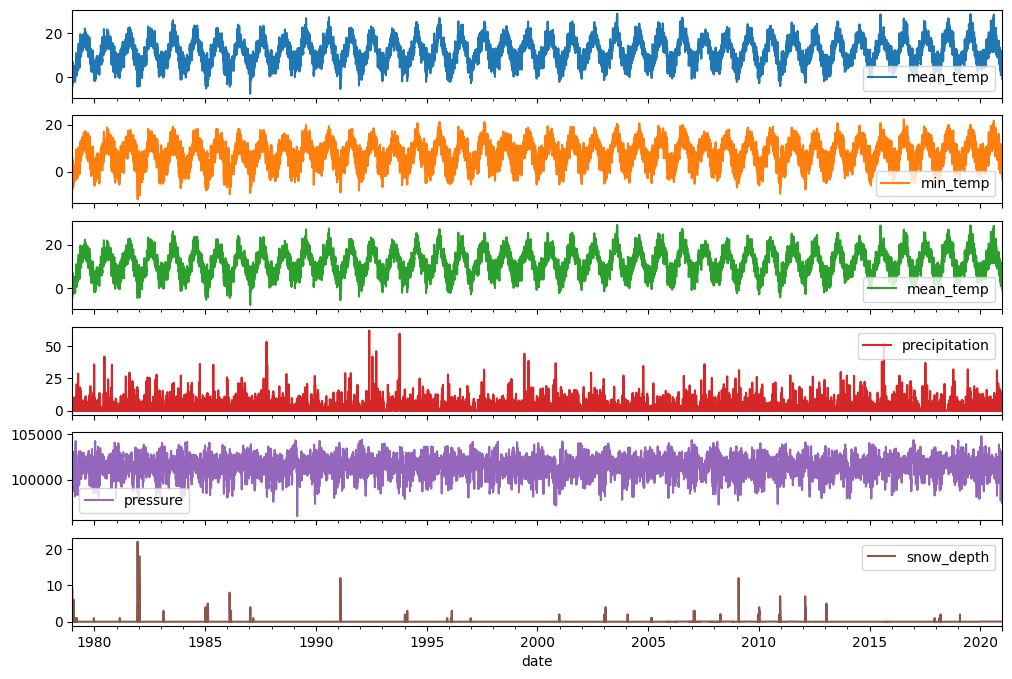

In [187]:
# plot all parameters against date in seperate plots
weather.plot(x='date', y=['mean_temp', 'min_temp','mean_temp', 'precipitation', 'pressure', 'snow_depth'], subplots=True, figsize=(12,8))
plt.show()

In [188]:
# feature selection and engineering
# check corelation of mean temperature with other parameters
corr = weather.corr()['mean_temp']
print(corr.sort_values(ascending=False))

weather.drop(columns=['date'], inplace=True)

mean_temp           1.000000
min_temp            0.954532
max_temp            0.911442
global_radiation    0.633862
sunshine            0.396130
month               0.226806
date                0.098959
year                0.093647
day                 0.009544
pressure            0.004758
precipitation      -0.010455
cloud_cover        -0.110273
snow_depth         -0.147051
Name: mean_temp, dtype: float64


In [189]:
# scale the numeric columns with standard scaler
scaler = StandardScaler()
#numeric_cols = weather.select_dtypes(include=[np.number]).columns
#weather[numeric_cols] = scaler.fit_transform(weather[numeric_cols])

weather[['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth', 'mean_temp']] = scaler.fit_transform(weather[['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth', 'mean_temp']])


In [190]:
# describe data in 2 decimal places
weather.describe().round(2)

,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth,day,month,year
count,15341.00,15341.00,15341.00,15341.00,15341.00,15341.00,15341.00,15341.00,15341.00,15341.00,15341.00,15341.00
mean,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,15.73,6.52,1999.50
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,8.80,3.45,12.12
min,-2.55,-1.08,-1.25,-3.29,-3.33,-3.63,-0.45,-5.31,-0.07,1.00,1.00,1979.00
25%,-0.61,-0.96,-0.88,-0.75,-0.76,-0.76,-0.45,-0.59,-0.07,8.00,4.00,1989.00
50%,0.35,-0.21,-0.27,-0.06,-0.01,0.05,-0.45,0.08,-0.07,16.00,7.00,2000.00
75%,0.84,0.71,0.76,0.75,0.79,0.80,-0.02,0.67,-0.07,23.00,10.00,2010.00
max,1.80,2.89,3.19,3.44,3.06,2.77,16.09,3.13,42.29,31.00,12.00,2020.00


In [191]:
# split weather data into test and train
train, test = train_test_split(weather, test_size=0.2, random_state=42)

# print the shape of train and test data
print(train.shape)
print(test.shape)


(12272, 12)
(3069, 12)


In [192]:

# Create test train split
X= weather.drop(columns=['mean_temp'])
y= weather['mean_temp']
# convert y to series
#y = pd.Series(y)




In [193]:
# train test split weather data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [194]:
# Define models and hyperparameters
models = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {'fit_intercept': [True, False],
            'n_jobs': [None, -1],
            'positive': [False, True],
            'copy_X': [True, False],
            'tol': [0.0001, 0.01]
        }
    },
    'DecissionTreeRegressor': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'RandomForestRegressor': {
        'model': RandomForestRegressor(),
        'params': {'n_estimators': [300,500],
            'max_depth': [None,5],
            'min_samples_split': [2,10],
            'min_samples_leaf': [1,2],
            'max_features': ['log2', 'sqrt']
        }
    }
}

In [195]:
# Set experiment
mlflow.set_experiment("London Mean Temperature Prediction")

<Experiment: artifact_location='file:///c:/venv/00.%20Projects/28_Predicting%20London%20temperatures/workspace/mlruns/436976833179389818', creation_time=1750159722803, experiment_id='436976833179389818', last_update_time=1750159722803, lifecycle_stage='active', name='London Mean Temperature Prediction', tags={}>

In [196]:
for model_name, model_info in models.items():
    with mlflow.start_run(run_name=model_name):
        model = model_info['model']
        params = model_info['params']
        
        if params:
            grid_search = GridSearchCV(model, params, cv=2)
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            
            mlflow.log_params(grid_search.best_params_)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        mlflow.log_metric("rmse", rmse)


In [197]:
# Search runs
client = mlflow.tracking.MlflowClient()
experiment_id = mlflow.get_experiment_by_name("London Mean Temperature Prediction").experiment_id
#experiment_results = client.search_runs(experiment_ids=experiment_id)
experiment_results = mlflow.search_runs(filter_string="metrics.rmse < 3.0")

In [198]:
for index, row in experiment_results.iterrows():
    rmse = row.get('metrics.rmse')
    if rmse is not None:
        print(f"Run ID: {row['run_id']}, Model: {row.get('tags.mlflow.runName')}, RMSE: {rmse}")

Run ID: f5198c0ec84a471890f3596ee3edd021, Model: RandomForestRegressor, RMSE: 0.15648314046329223
Run ID: 043a0f4609be4b5b9ba33bf12fb70e7d, Model: DecissionTreeRegressor, RMSE: 0.18006978748630964
Run ID: 0271c0d5e86043a5887117a8f395d837, Model: LinearRegression, RMSE: 0.1599749721006817
Run ID: 49cd0a9f6cac45b1a74ea08404803965, Model: RandomForestRegressor, RMSE: 0.15738617098111832
Run ID: 32993811e2254a28b7ce4ea26f62fce0, Model: DecissionTreeRegressor, RMSE: 0.18002168872512272
Run ID: fd55e8a90e2f438980584ed8099d0dc9, Model: LinearRegression, RMSE: 0.1599749721006817
Run ID: bbab79d71fbf4b08b84f1a1e3fb0506d, Model: RandomForestRegressor, RMSE: 0.1573727522783262
Run ID: 54d502b72fad4980b103dfe588bb81b7, Model: DecissionTreeRegressor, RMSE: 0.18006978748630964
Run ID: ae04629419be4d06a659ca35582458d3, Model: LinearRegression, RMSE: 0.1599749721006817
Run ID: 6422f04d5e1c40d1a7250992c1a179f1, Model: RandomForestRegressor, RMSE: 0.15707885196848628
Run ID: 7fdf6d50a20b457e9132700fcd9c

In [200]:
# Find the best model (ignore runs without 'rmse')
if not experiment_results.empty and 'metrics.rmse' in experiment_results.columns:
	best_row = experiment_results.loc[experiment_results['metrics.rmse'].idxmin()]
	print(f"Best Run ID: {best_row['run_id']}, Model: {best_row['tags.mlflow.runName']}, RMSE: {best_row['metrics.rmse']}")
else:
	print("No runs with 'rmse' metric found.")

Best Run ID: f5198c0ec84a471890f3596ee3edd021, Model: RandomForestRegressor, RMSE: 0.15648314046329223


In [201]:
mlflow.end_run()

In MLflow, you don't need to explicitly close an experiment. However, you can end a run using mlflow.end_run() or by using the with mlflow.start_run() context manager, which automatically ends the run when you exit the block.

If you want to restart an experiment, you can simply start a new run using mlflow.start_run() or the with mlflow.start_run() context manager. MLflow will automatically create a new run ID and log the metrics and parameters for the new run.

Here's an example:


import mlflow

# Start a new run
with mlflow.start_run():
    # Log metrics and parameters
    mlflow.log_param("param1", 1)
    mlflow.log_metric("metric1", 1.0)

# Start another run
with mlflow.start_run():
    # Log metrics and parameters
    mlflow.log_param("param2", 2)
    mlflow.log_metric("metric2", 2.0)


In this example, MLflow will create two separate runs with different run IDs.

If you want to delete an experiment or a run, you can use the MLflow client API:


client = mlflow.tracking.MlflowClient()
experiment_id = mlflow.get_experiment_by_name("My Experiment").experiment_id
client.delete_experiment(experiment_id)


Or, to delete a run:


client.delete_run(run_id)